In [6]:
import os
import sys
from pathlib import Path

curr_dir = Path(os.path.split(os.getcwd())[0])

api_dir = str(curr_dir)
if api_dir not in sys.path:
    sys.path.insert(0, api_dir)

import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from src.model.classifier import Classifier
from src.xbox2_specific.datasets.XBOX2_trend_all_bd_20ms import XBOX2TrendAllBD20msSelect
from src.utils.dataset_creator import load_dataset

# Load Dataset
To load a dataset the dataset name and path to data has to be supplied.
This information is then passed to the `load_dataset` function which returns training, validation and test set.

For the xbox2 dataset some additional information is passed to the dataset loader.
First, the `manual_split` argument can be used to specify custom splitting of the data using run numbers.
Secondly, the `manual_scale` argument can be used to specify if scaling should
be done using mean and variance of each run.

In [7]:
train_runs = [2, 4, 5, 6, 8, 9]
valid_runs = [1, 7]
test_runs = [3]

path_to_data = Path("/eos/project/m/ml-for-alarm-system/private/CLIC_data_transfert/Xbox2_hdf_new2/")

train, valid, test = load_dataset(creator=XBOX2TrendAllBD20msSelect(),
                                  data_path=path_to_data,
                                  manual_split=(train_runs, valid_runs, test_runs),
                                  manual_scale=[1, 2, 3, 4, 5, 6, 7, 8, 9])

OSError: Unable to open file (unable to open file: name = '\eos\project\m\ml-for-alarm-system\private\CLIC_data_transfert\Xbox2_hdf_new2\context.hdf', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

# Plot Dataset
A good sanity check is to plot the data and checking if the data looks as expected.

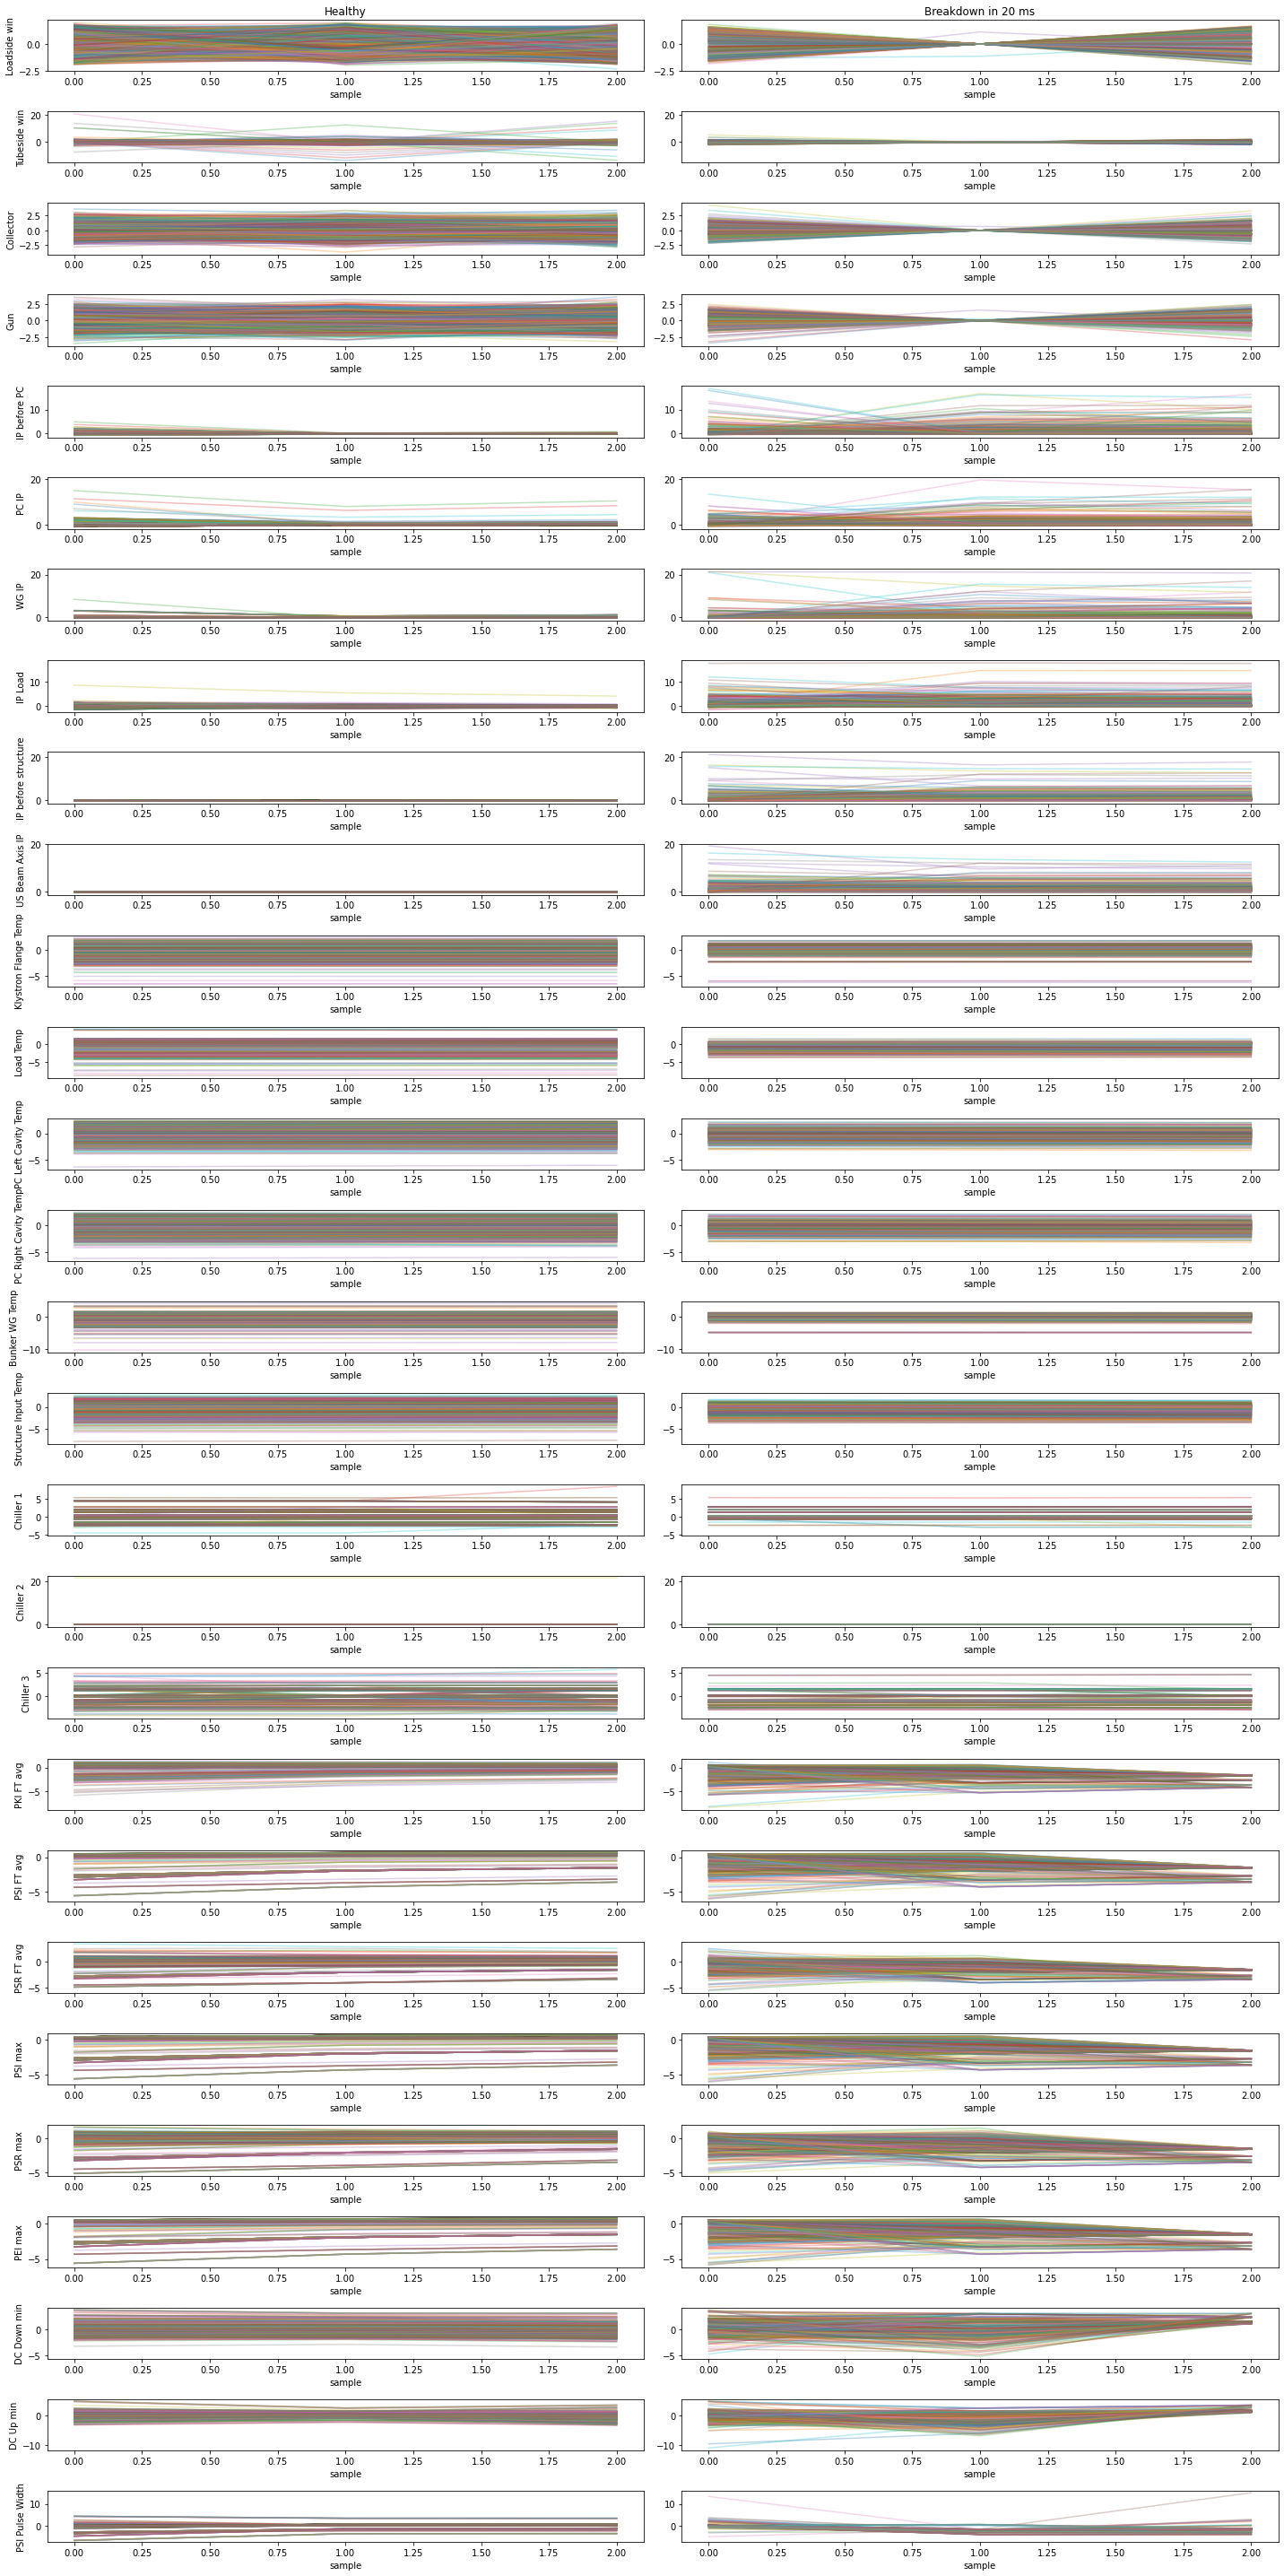

In [3]:
n_features = len(train.X[0, 0, :])

# Names of features in trend data
feature_list = ["Loadside win", "Tubeside win",
                "Collector", "Gun", "IP before PC",
                "PC IP", "WG IP", "IP Load",
                "IP before structure", "US Beam Axis IP",
                "Klystron Flange Temp", "Load Temp",
                "PC Left Cavity Temp", "PC Right Cavity Temp",
                "Bunker WG Temp", "Structure Input Temp",
                "Chiller 1", "Chiller 2", "Chiller 3",
                "PKI FT avg", "PSI FT avg", "PSR FT avg",
                "PSI max", "PSR max", "PEI max",
                "DC Down min", "DC Up min",
                "PSI Pulse Width"]

fig, ax = plt.subplots(n_features,2, figsize=(20,60))
for i in range(n_features):
    ax[i, 0].plot(train.X[train.y.argmax(axis=1) == 0][:,:,i].T, alpha=0.3)
    ax[i, 0].set_xlabel("sample")
    ax[i, 0].set_ylabel(feature_list[i])
    ax[i, 0].set_xticks([0, 1, 2])
    ax[i, 1].plot(train.X[train.y.argmax(axis=1) == 1][:,:,i].T, alpha=0.3)
    ax[i, 1].set_xlabel("sample")
    ax[i, 1].set_xticks([0, 1, 2])
    bottom0, top0 = ax[i, 0].set_ylim()
    bottom1, top1 = ax[i, 1].set_ylim()
    ax[i, 0].set_ylim([min([bottom0, bottom1]), max([top0, top1])])
    ax[i, 1].set_ylim([min([bottom0, bottom1]), max([top0, top1])])

ax[0, 0].set_title("Healthy")
ax[0, 1].set_title("Breakdown in 20 ms")
fig.tight_layout()
plt.show()

# Create and Use Classifier Model
To create a classifier model an instance of the `Classifier` class is created.
To do this some hyperparameters are needed. These are loaded from a ´.json´ file.

In [4]:
# Load hyperparameters into dictionary
hp_file = open(Path(api_dir) / "src/model/default_hyperparameters.json")
hp_dict = json.load(hp_file)

# Create model
clf = Classifier(input_shape=train.X.shape, output_directory=Path(api_dir) / "src/output", **hp_dict)

## Fit Model
After the model is created it has to be fitted to the data. This is done using the `fit_classifier` method.
Alternatively if a model already has been trained, the trained weights can be loaded.
In this example we simply load pretrained weights as training is time-consuming.

In [5]:
# Fit model to training set and validate on validation set
# clf.fit_classifier(train, valid)
# load weights from an already trained model
clf.model.load_weights(Path(api_dir) / "src/model/trained_models/trend_all_bd_20ms.hdf5")

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/250
135/135 [==============================] - 7s 17ms/step - loss: 0.6043 - tp: 1942.0000 - fp: 203.0000 - tn: 1942.0000 - fn: 203.0000 - accuracy: 0.9054 - precision: 0.9054 - recall: 0.9054 - auc: 0.9675 - prc: 0.9610 - val_loss: 0.1095 - val_tp: 585.0000 - val_fp: 18.0000 - val_tn: 585.0000 - val_fn: 18.0000 - val_accuracy: 0.9701 - val_precision: 0.9701 - val_recall: 0.9701 - val_auc: 0.9923 - val_prc: 0.9903
Epoch 2/250
135/135 [==============================] - 1s 10ms/step - loss: 0.1476 - tp: 2122.0000 - fp: 23.0000 - tn: 2122.0000 - fn: 23.0000 - accuracy: 0.9893 - precision: 0.9893 - recall: 0.9893 - auc: 0.9933 - prc: 0.9913 - val_loss: 0.0107 - val_tp: 600.0000 - val_fp: 3.0000 - val_tn: 600.0000 - val_fn: 3.0000 - val_accuracy: 0.9950 - val_precision: 0.9950 - val_recall: 0.9950 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 3/250
13

135/135 [==============================] - 1s 11ms/step - loss: 2.5773e-06 - tp: 2145.0000 - fp: 0.0000e+00 - tn: 2145.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0267 - val_tp: 599.0000 - val_fp: 4.0000 - val_tn: 599.0000 - val_fn: 4.0000 - val_accuracy: 0.9934 - val_precision: 0.9934 - val_recall: 0.9934 - val_auc: 0.9982 - val_prc: 0.9977
Epoch 20/250
135/135 [==============================] - 1s 11ms/step - loss: 2.2091e-06 - tp: 2145.0000 - fp: 0.0000e+00 - tn: 2145.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0265 - val_tp: 599.0000 - val_fp: 4.0000 - val_tn: 599.0000 - val_fn: 4.0000 - val_accuracy: 0.9934 - val_precision: 0.9934 - val_recall: 0.9934 - val_auc: 0.9982 - val_prc: 0.9977
Epoch 21/250
135/135 [==============================] - 2s 11ms/step - loss: 1.8952e-06 - tp: 2145.0000 - fp: 0.0000e+00 - tn: 2145.0000 - fn: 0.00

Epoch 38/250
135/135 [==============================] - 2s 18ms/step - loss: 3.0778e-07 - tp: 2145.0000 - fp: 0.0000e+00 - tn: 2145.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0251 - val_tp: 599.0000 - val_fp: 4.0000 - val_tn: 599.0000 - val_fn: 4.0000 - val_accuracy: 0.9934 - val_precision: 0.9934 - val_recall: 0.9934 - val_auc: 0.9983 - val_prc: 0.9977
Epoch 39/250
135/135 [==============================] - 2s 18ms/step - loss: 2.9588e-07 - tp: 2145.0000 - fp: 0.0000e+00 - tn: 2145.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0251 - val_tp: 599.0000 - val_fp: 4.0000 - val_tn: 599.0000 - val_fn: 4.0000 - val_accuracy: 0.9934 - val_precision: 0.9934 - val_recall: 0.9934 - val_auc: 0.9983 - val_prc: 0.9977
Epoch 40/250
135/135 [==============================] - 2s 14ms/step - loss: 2.7860e-07 - tp: 2145.0000 - fp: 0.0000e+00 - tn: 2145.00

135/135 [==============================] - 2s 18ms/step - loss: 7.7750e-08 - tp: 2145.0000 - fp: 0.0000e+00 - tn: 2145.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0243 - val_tp: 599.0000 - val_fp: 4.0000 - val_tn: 599.0000 - val_fn: 4.0000 - val_accuracy: 0.9934 - val_precision: 0.9934 - val_recall: 0.9934 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 57/250
135/135 [==============================] - 3s 19ms/step - loss: 6.4356e-08 - tp: 2145.0000 - fp: 0.0000e+00 - tn: 2145.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0243 - val_tp: 599.0000 - val_fp: 4.0000 - val_tn: 599.0000 - val_fn: 4.0000 - val_accuracy: 0.9934 - val_precision: 0.9934 - val_recall: 0.9934 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 58/250
135/135 [==============================] - 2s 18ms/step - loss: 5.2685e-08 - tp: 2145.0000 - fp: 0.0000e+00 - tn: 2145.0000 - fn: 0.00

Epoch 75/250
135/135 [==============================] - 2s 12ms/step - loss: 1.9785e-08 - tp: 2145.0000 - fp: 0.0000e+00 - tn: 2145.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0226 - val_tp: 599.0000 - val_fp: 4.0000 - val_tn: 599.0000 - val_fn: 4.0000 - val_accuracy: 0.9934 - val_precision: 0.9934 - val_recall: 0.9934 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 76/250
135/135 [==============================] - 2s 14ms/step - loss: 1.8896e-08 - tp: 2145.0000 - fp: 0.0000e+00 - tn: 2145.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0226 - val_tp: 599.0000 - val_fp: 4.0000 - val_tn: 599.0000 - val_fn: 4.0000 - val_accuracy: 0.9934 - val_precision: 0.9934 - val_recall: 0.9934 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 77/250
135/135 [==============================] - 2s 17ms/step - loss: 1.8562e-08 - tp: 2145.0000 - fp: 0.0000e+00 - tn: 2145.00

Epoch 94/250
135/135 [==============================] - 2s 12ms/step - loss: 3.0566e-09 - tp: 2145.0000 - fp: 0.0000e+00 - tn: 2145.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0217 - val_tp: 599.0000 - val_fp: 4.0000 - val_tn: 599.0000 - val_fn: 4.0000 - val_accuracy: 0.9934 - val_precision: 0.9934 - val_recall: 0.9934 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 95/250
135/135 [==============================] - 2s 12ms/step - loss: 2.8899e-09 - tp: 2145.0000 - fp: 0.0000e+00 - tn: 2145.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0215 - val_tp: 599.0000 - val_fp: 4.0000 - val_tn: 599.0000 - val_fn: 4.0000 - val_accuracy: 0.9934 - val_precision: 0.9934 - val_recall: 0.9934 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 96/250
135/135 [==============================] - 2s 12ms/step - loss: 2.7232e-09 - tp: 2145.0000 - fp: 0.0000e+00 - tn: 2145.00

135/135 [==============================] - 3s 19ms/step - loss: 1.2782e-09 - tp: 2145.0000 - fp: 0.0000e+00 - tn: 2145.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0212 - val_tp: 599.0000 - val_fp: 4.0000 - val_tn: 599.0000 - val_fn: 4.0000 - val_accuracy: 0.9934 - val_precision: 0.9934 - val_recall: 0.9934 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 113/250
135/135 [==============================] - 2s 15ms/step - loss: 1.2782e-09 - tp: 2145.0000 - fp: 0.0000e+00 - tn: 2145.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0212 - val_tp: 599.0000 - val_fp: 4.0000 - val_tn: 599.0000 - val_fn: 4.0000 - val_accuracy: 0.9934 - val_precision: 0.9934 - val_recall: 0.9934 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 114/250
135/135 [==============================] - 2s 13ms/step - loss: 1.2782e-09 - tp: 2145.0000 - fp: 0.0000e+00 - tn: 2145.0000 - fn: 0.

135/135 [==============================] - 3s 19ms/step - loss: 7.2248e-10 - tp: 2145.0000 - fp: 0.0000e+00 - tn: 2145.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0214 - val_tp: 599.0000 - val_fp: 4.0000 - val_tn: 599.0000 - val_fn: 4.0000 - val_accuracy: 0.9934 - val_precision: 0.9934 - val_recall: 0.9934 - val_auc: 0.9983 - val_prc: 0.99780 - fp: 0.0000e+00 - tn: 2096.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.000
Epoch 130/250
135/135 [==============================] - 3s 19ms/step - loss: 7.2248e-10 - tp: 2145.0000 - fp: 0.0000e+00 - tn: 2145.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0215 - val_tp: 599.0000 - val_fp: 4.0000 - val_tn: 599.0000 - val_fn: 4.0000 - val_accuracy: 0.9934 - val_precision: 0.9934 - val_recall: 0.9934 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 131/25

Epoch 147/250
135/135 [==============================] - 2s 13ms/step - loss: 2.2230e-10 - tp: 2145.0000 - fp: 0.0000e+00 - tn: 2145.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0220 - val_tp: 599.0000 - val_fp: 4.0000 - val_tn: 599.0000 - val_fn: 4.0000 - val_accuracy: 0.9934 - val_precision: 0.9934 - val_recall: 0.9934 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 148/250
135/135 [==============================] - 2s 15ms/step - loss: 2.2230e-10 - tp: 2145.0000 - fp: 0.0000e+00 - tn: 2145.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0220 - val_tp: 599.0000 - val_fp: 4.0000 - val_tn: 599.0000 - val_fn: 4.0000 - val_accuracy: 0.9934 - val_precision: 0.9934 - val_recall: 0.9934 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 149/250
135/135 [==============================] - 2s 17ms/step - loss: 2.2230e-10 - tp: 2145.0000 - fp: 0.0000e+00 - tn: 2145

135/135 [==============================] - 2s 16ms/step - loss: 5.5575e-11 - tp: 2145.0000 - fp: 0.0000e+00 - tn: 2145.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0229 - val_tp: 599.0000 - val_fp: 4.0000 - val_tn: 599.0000 - val_fn: 4.0000 - val_accuracy: 0.9934 - val_precision: 0.9934 - val_recall: 0.9934 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 166/250
135/135 [==============================] - 2s 13ms/step - loss: 1.1115e-10 - tp: 2145.0000 - fp: 0.0000e+00 - tn: 2145.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0228 - val_tp: 599.0000 - val_fp: 4.0000 - val_tn: 599.0000 - val_fn: 4.0000 - val_accuracy: 0.9934 - val_precision: 0.9934 - val_recall: 0.9934 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 167/250
135/135 [==============================] - 2s 12ms/step - loss: 5.5575e-11 - tp: 2145.0000 - fp: 0.0000e+00 - tn: 2145.0000 - fn: 0.

135/135 [==============================] - 3s 19ms/step - loss: 0.0000e+00 - tp: 2145.0000 - fp: 0.0000e+00 - tn: 2145.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0246 - val_tp: 598.0000 - val_fp: 5.0000 - val_tn: 598.0000 - val_fn: 5.0000 - val_accuracy: 0.9917 - val_precision: 0.9917 - val_recall: 0.9917 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 184/250
135/135 [==============================] - 2s 18ms/step - loss: 0.0000e+00 - tp: 2145.0000 - fp: 0.0000e+00 - tn: 2145.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0246 - val_tp: 598.0000 - val_fp: 5.0000 - val_tn: 598.0000 - val_fn: 5.0000 - val_accuracy: 0.9917 - val_precision: 0.9917 - val_recall: 0.9917 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 185/250
135/135 [==============================] - 2s 15ms/step - loss: 0.0000e+00 - tp: 2145.0000 - fp: 0.0000e+00 - tn: 2145.0000 - fn: 0.

Epoch 202/250
135/135 [==============================] - 2s 12ms/step - loss: 0.0000e+00 - tp: 2145.0000 - fp: 0.0000e+00 - tn: 2145.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0255 - val_tp: 598.0000 - val_fp: 5.0000 - val_tn: 598.0000 - val_fn: 5.0000 - val_accuracy: 0.9917 - val_precision: 0.9917 - val_recall: 0.9917 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 203/250
135/135 [==============================] - 2s 12ms/step - loss: 0.0000e+00 - tp: 2145.0000 - fp: 0.0000e+00 - tn: 2145.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0254 - val_tp: 598.0000 - val_fp: 5.0000 - val_tn: 598.0000 - val_fn: 5.0000 - val_accuracy: 0.9917 - val_precision: 0.9917 - val_recall: 0.9917 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 204/250
135/135 [==============================] - 2s 13ms/step - loss: 0.0000e+00 - tp: 2145.0000 - fp: 0.0000e+00 - tn: 2145

Epoch 221/250
135/135 [==============================] - 2s 15ms/step - loss: 0.0000e+00 - tp: 2145.0000 - fp: 0.0000e+00 - tn: 2145.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0256 - val_tp: 598.0000 - val_fp: 5.0000 - val_tn: 598.0000 - val_fn: 5.0000 - val_accuracy: 0.9917 - val_precision: 0.9917 - val_recall: 0.9917 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 222/250
135/135 [==============================] - 2s 14ms/step - loss: 0.0000e+00 - tp: 2145.0000 - fp: 0.0000e+00 - tn: 2145.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0256 - val_tp: 598.0000 - val_fp: 5.0000 - val_tn: 598.0000 - val_fn: 5.0000 - val_accuracy: 0.9917 - val_precision: 0.9917 - val_recall: 0.9917 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 223/250
135/135 [==============================] - 2s 12ms/step - loss: 0.0000e+00 - tp: 2145.0000 - fp: 0.0000e+00 - tn: 2145

Epoch 240/250
135/135 [==============================] - 2s 12ms/step - loss: 0.0000e+00 - tp: 2145.0000 - fp: 0.0000e+00 - tn: 2145.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0259 - val_tp: 598.0000 - val_fp: 5.0000 - val_tn: 598.0000 - val_fn: 5.0000 - val_accuracy: 0.9917 - val_precision: 0.9917 - val_recall: 0.9917 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 241/250
135/135 [==============================] - 2s 13ms/step - loss: 0.0000e+00 - tp: 2145.0000 - fp: 0.0000e+00 - tn: 2145.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0259 - val_tp: 598.0000 - val_fp: 5.0000 - val_tn: 598.0000 - val_fn: 5.0000 - val_accuracy: 0.9917 - val_precision: 0.9917 - val_recall: 0.9917 - val_auc: 0.9983 - val_prc: 0.9978
Epoch 242/250
135/135 [==============================] - 2s 13ms/step - loss: 0.0000e+00 - tp: 2145.0000 - fp: 0.0000e+00 - tn: 2145

## Make Prediction
When the model has been fitted to the data, it can be used to make predictions.
Here the prediction is done on the kept out test set using the `predict` method.

In [6]:
y_pred = clf.model.predict(x=test.X)

## Evaluate Model
To evaluate the performance of the model, the `evaluate` method can be used.

In [ ]:
# eval classifier
results = clf.model.evaluate(x=test.X, y=test.y, return_dict=True)
pd.DataFrame.from_dict(results, orient='index').T